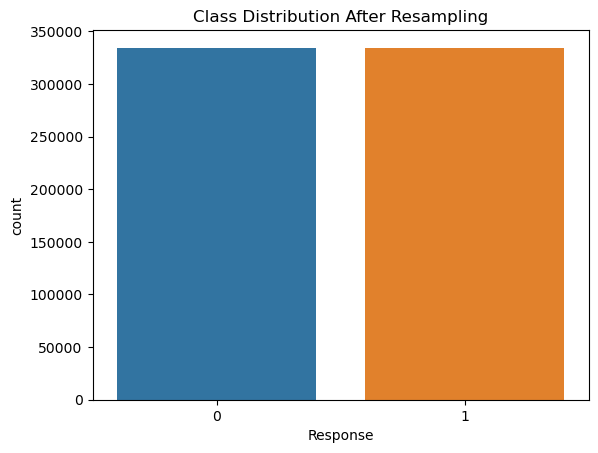

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import os
import tempfile

# Load and preprocess the data
df = pd.read_csv('/Users/da-m1-18/Downloads/car_insurance_claim.csv')

# Encode categorical variables
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df['Vehicle_Age'] = label_encoder.fit_transform(df['Vehicle_Age'])
df['Vehicle_Damage'] = label_encoder.fit_transform(df['Vehicle_Damage'])

# Select relevant features and target
selected_features = ['Gender', 'Age', 'Annual_Premium', 'Vehicle_Damage', 'Vehicle_Age', 'Previously_Insured']
X = df[selected_features]
y = df['Response']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Check the class distribution after resampling
sns.countplot(x=y_resampled)
plt.title('Class Distribution After Resampling')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
16720/16720 ━━━━━━━━━━━━━━━━━━━━ 12s 633us/step - accuracy: 0.7603 - loss: 0.4967 - val_accuracy: 0.7903 - val_loss: 0.4337
Epoch 2/100
16720/16720 ━━━━━━━━━━━━━━━━━━━━ 10s 606us/step - accuracy: 0.7813 - loss: 0.4595 - val_accuracy: 0.7918 - val_loss: 0.4322
Epoch 3/100
16720/16720 ━━━━━━━━━━━━━━━━━━━━ 10s 616us/step - accuracy: 0.7837 - loss: 0.4553 - val_accuracy: 0.7921 - val_loss: 0.4327
Epoch 4/100
16720/16720 ━━━━━━━━━━━━━━━━━━━━ 10s 602us/step - accuracy: 0.7836 - loss: 0.4564 - val_accuracy: 0.7924 - val_loss: 0.4329
Epoch 5/100
16720/16720 ━━━━━━━━━━━━━━━━━━━━ 10s 606us/step - accuracy: 0.7828 - loss: 0.4553 - val_accuracy: 0.7916 - val_loss: 0.4322
Epoch 6/100
16720/16720 ━━━━━━━━━━━━━━━━━━━━ 10s 608us/step - accuracy: 0.7832 - loss: 0.4556 - val_accuracy: 0.7914 - val_loss: 0.4330
Epoch 7/100
16720/16720 ━━━━━━━━━━━━━━━━━━━━ 11s 673us/step - accuracy: 0.7840 - loss: 0.4559 - val_accuracy: 0.7924 - val_loss: 0.4324
Epoch 8/100
16720/16720 ━━━━━━━━━━━━━━━━━━━━ 10s

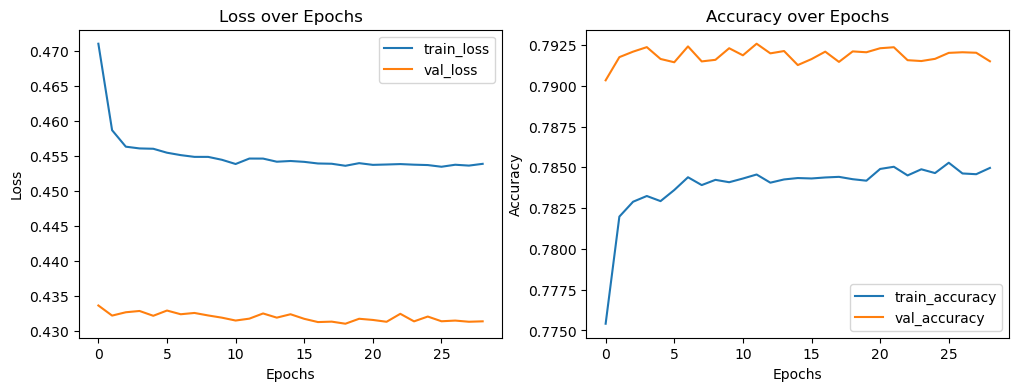

4180/4180 ━━━━━━━━━━━━━━━━━━━━ 1s 257us/step - accuracy: 0.7918 - loss: 0.4322
Test Loss: 0.4310774505138397
Test Accuracy: 0.7921052575111389


In [2]:
# Build the model
def build_model():
    model = Sequential([
        Dense(64, input_dim=X_train.shape[1], activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create a temporary directory to save the model
with tempfile.TemporaryDirectory() as tmpdirname:
    model_checkpoint = ModelCheckpoint(os.path.join(tmpdirname, 'best_model.keras'), save_best_only=True)

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping, model_checkpoint])

    # Plot training history
    def plot_history(history):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='train_loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss over Epochs')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='train_accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy over Epochs')

        plt.show()

    plot_history(history)

    # Load the best model
    best_model = tf.keras.models.load_model(os.path.join(tmpdirname, 'best_model.keras'))

    # Save the model to a permanent location
    permanent_model_path = '/Users/da-m1-18/best_model_final.keras'
    best_model.save(permanent_model_path)

    # Evaluate on the test set
    test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
